# Format Europe energy demand

Data are hourly, country aggregates, from ENTSOE: https://www.entsoe.eu/data/power-stats/

In [1]:
import pandas as pd

In [2]:
data_path = "/g/data/w42/dr6273/work/data/ENTSOE/"

In [3]:
hourly = pd.read_csv(
    data_path+"Monthly-hourly-load-values_2006-2015.csv",
    skiprows=3,
    header=0,
    parse_dates={'timestamp': ['Year','Month', "Day"]},
    index_col="timestamp",
    # usecols=["Date", "Time", "NSW1", "QLD1", "SA1", "TAS1", "VIC1"]
)

### Important!

Some countries don't have the full range of data. E.g. GB starts in 2010, IE in 2008. So, let's average across regions instead of sum.

Sum over hours

In [4]:
daily = hourly[["Country", "Coverage ratio"]]

In [5]:
daily["Unscaled power (MWh/day)"] = hourly.iloc[:,2:].sum(axis=1)

/jobfs/91894382.gadi-pbs/ipykernel_1199019/65306476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily["Unscaled power (MWh/day)"] = hourly.iloc[:,2:].sum(axis=1)


According to the data, "To get the real value, you need to scale them to 100% for coverage ratio less than 100."

In [6]:
def scale(ratio, value):
    """
    Scale the value to 100% coverage
    
    ratio: coverage ration (%)
    value: value to scale to 100
    """
    return value / (ratio / 100) 

In [7]:
daily["Power (MWh/day)"] = daily.apply(
    lambda x : scale(x['Coverage ratio'], x["Unscaled power (MWh/day)"]), axis=1
)

/jobfs/91894382.gadi-pbs/ipykernel_1199019/2149852256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily["Power (MWh/day)"] = daily.apply(


In [8]:
daily = daily.drop("Unscaled power (MWh/day)", axis=1)
daily = daily.drop("Coverage ratio", axis=1)

Only keep the following countries: Austria, Belgium, Denmark, France, Germany, Ireland, Italy, Luxembourg, the Netherlands, Norway, Portugal, Spain, Sweden, Switzerland and the UK.

In [9]:
daily["Country"].unique()

array(['AT', 'BA', 'BE', 'BG', 'CH', 'CS', 'CY', 'CZ', 'DE', 'DK', 'DK_W',
       'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT',
       'LT', 'LU', 'LV', 'ME', 'MK', 'NI', 'NL', 'NO', 'PL', 'PT', 'RO',
       'RS', 'SE', 'SI', 'SK', 'UA_W'], dtype=object)

In [10]:
codes = ["AT", "BE", "DK", "FR", "DE", "IE", "IT", "LU", "NL", "NO", "PT", "ES", "SE", "CH", "GB"]
len(codes)

15

In [11]:
daily = daily.loc[daily["Country"].isin(codes)]

Years available for each country

In [14]:
daily.groupby("Country").apply(lambda x: (x.index[0], x.index[-1]))

Country
AT    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
BE    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
CH    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
DE    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
DK    (2010-01-01 00:00:00, 2015-12-31 00:00:00)
ES    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
FR    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
GB    (2010-01-01 00:00:00, 2015-12-31 00:00:00)
IE    (2008-01-01 00:00:00, 2015-12-31 00:00:00)
IT    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
LU    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
NL    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
NO    (2010-01-01 00:00:00, 2015-12-31 00:00:00)
PT    (2006-01-01 00:00:00, 2015-12-31 00:00:00)
SE    (2010-01-01 00:00:00, 2015-12-31 00:00:00)
dtype: object

In [19]:
set_2006 = [i for i in codes if i not in ["DK", "GB", "IE", "NO", "SE"]]
set_2006

['AT', 'BE', 'FR', 'DE', 'IT', 'LU', 'NL', 'PT', 'ES', 'CH']

Average over all countries

In [40]:
# daily = daily.groupby(daily.index).mean(numeric_only=True)

In [41]:
daily_2006_2015 = daily.loc[daily["Country"].isin(set_2006)]
daily_2006_2015 = daily_2006_2015.groupby(daily_2006_2015.index).sum(numeric_only=True)

In [42]:
daily_2010_2015 = daily.loc[daily.index >= "2010"]
daily_2010_2015 = daily_2010_2015.groupby(daily_2010_2015.index).sum(numeric_only=True)

In [43]:
daily_2006_2015.head()

,Power (MWh/day)
timestamp,
2006-01-01,4.559343e+06
2006-01-02,5.558190e+06
2006-01-03,5.934828e+06
2006-01-04,6.043556e+06
2006-01-05,6.128658e+06


In [44]:
daily_2010_2015.head()

,Power (MWh/day)
timestamp,
2010-01-01,5.726479e+06
2010-01-02,6.236515e+06
2010-01-03,6.233242e+06
2010-01-04,7.285739e+06
2010-01-05,7.554659e+06


<AxesSubplot: xlabel='timestamp'>

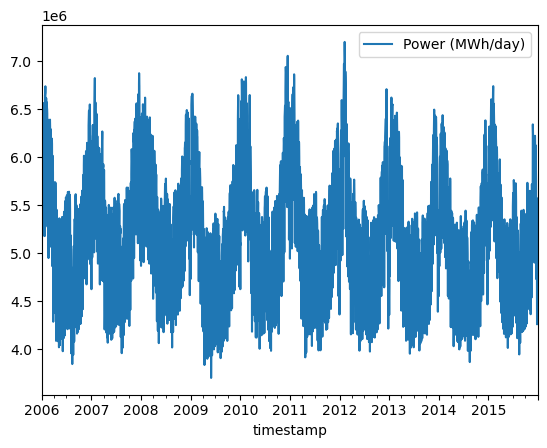

In [46]:
daily_2006_2015.plot()

<AxesSubplot: xlabel='timestamp'>

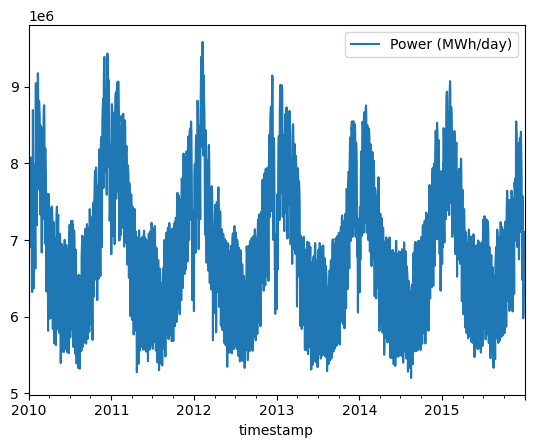

In [47]:
daily_2010_2015.plot()

In [26]:
daily.to_csv(
    data_path+"EU_daily_avg_demand_2006-2015.csv"
)

In [48]:
daily_2006_2015.to_csv(
    data_path+"EU_subset_daily_demand_2006-2015.csv"
)

In [49]:
daily_2010_2015.to_csv(
    data_path+"EU_daily_demand_2010-2015.csv"
)